In [3]:
# !pip install seaborn

In [4]:
# step_2_topic_discovery.ipynb (consultant-grade modular pipeline)

import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

C:\Users\arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# -------------------- 1. Load Cleaned Data --------------------
def load_cleaned_queries(filepath):
    df = pd.read_csv(filepath)
    if 'cleaned_query' not in df.columns:
        raise ValueError("Missing 'cleaned_query' column in uploaded file.")
    return df


In [6]:
# -------------------- 2. Generate Sentence Embeddings --------------------
def embed_queries(queries):
    # model = SentenceTransformer("all-MiniLM-L6-v2")
    model = SentenceTransformer("BAAI/bge-small-en-v1.5")
    embeddings = model.encode(queries.tolist(), show_progress_bar=True)
    return embeddings


In [7]:
# -------------------- 3. Cluster Embeddings --------------------
def cluster_queries(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels


In [8]:
# -------------------- 4. Add Topics --------------------
def assign_topics(df, labels):
    df['topic'] = labels
    return df

In [ ]:
# -------------------- 7. Save Output --------------------
def save_labeled_queries(df, output_path="clustered_queries_k25.csv"):
    df.to_csv(output_path, index=False)
    print(f"\n✅ Clustered data saved to: {output_path}")



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_practical_k(k_range, silhouette_scores, inertias, sil_thresh=0.005, inertia_thresh=0.05):
    """
    Picks smallest k where improvement slows down based on thresholds.
    """
    for i in range(1, len(k_range)):
        sil_gain = silhouette_scores[i] - silhouette_scores[i-1]
        inertia_drop = (inertias[i-1] - inertias[i]) / inertias[i-1]
        
        if sil_gain < sil_thresh and inertia_drop < inertia_thresh:
            return k_range[i]
    return k_range[-1]  # fallback to last if never meets criteria

def evaluate_silhouette_elbow(embeddings, k_range=range(5, 50, 5)):
    silhouette_scores = []
    inertias = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(embeddings, labels))
        inertias.append(kmeans.inertia_)
        print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, Inertia={inertias[-1]:.2f}")

    practical_k = find_practical_k(k_range, silhouette_scores, inertias, sil_thresh=0.006, inertia_thresh=0.1)

    print(f"\nPractical optimal k: {practical_k}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(k_range, silhouette_scores, marker='o')
    axs[0].set_title("Silhouette Score")
    axs[0].axvline(x=practical_k, color='r', linestyle='--', label=f'Chosen k={practical_k}')
    axs[0].legend()

    axs[1].plot(k_range, inertias, marker='s', color='orange')
    axs[1].set_title("Elbow Method (Inertia)")
    axs[1].axvline(x=practical_k, color='r', linestyle='--')
    axs[1].legend([f'Chosen k={practical_k}'])

    plt.tight_layout()
    plt.show()

    return practical_k


Batches: 100%|██████████| 204/204 [00:20<00:00,  9.99it/s]


k=5: Silhouette=0.1108, Inertia=1806.41
k=10: Silhouette=0.1766, Inertia=1455.36
k=15: Silhouette=0.2049, Inertia=1249.55
k=20: Silhouette=0.2338, Inertia=1087.55
k=25: Silhouette=0.2323, Inertia=986.81
k=30: Silhouette=0.2341, Inertia=925.96
k=35: Silhouette=0.2369, Inertia=883.10
k=40: Silhouette=0.2322, Inertia=828.25
k=45: Silhouette=0.2346, Inertia=791.84

Practical optimal k: 25


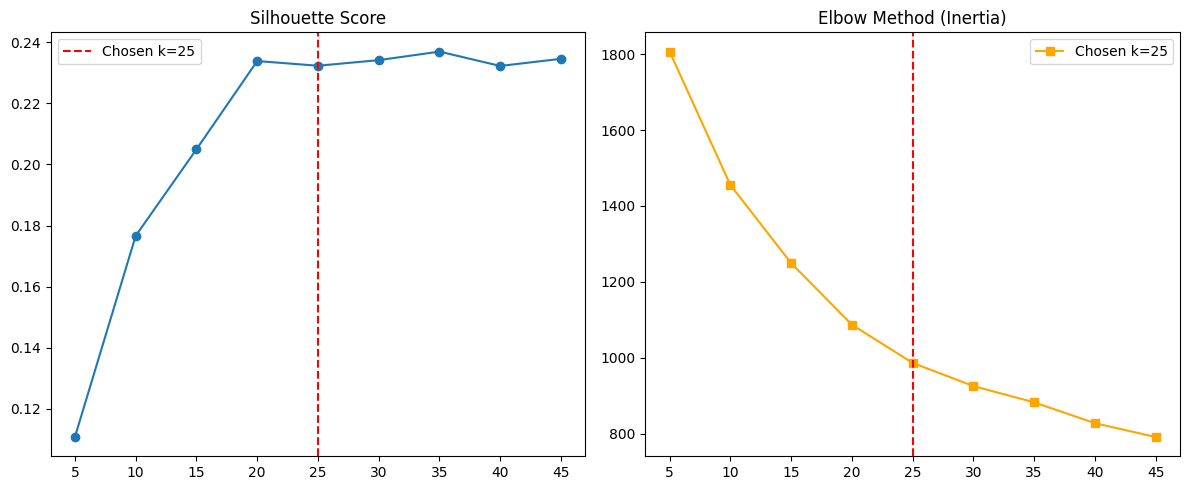

25

In [11]:
# -------------------- 8. Run Full Step 2 Pipeline --------------------

df = load_cleaned_queries("cleaned_queries.csv")
embeddings = embed_queries(df['cleaned_query'])
evaluate_silhouette_elbow(embeddings)



In [ ]:
# labels = cluster_queries(embeddings, n_clusters=25)
# df = assign_topics(df, labels)
# save_labeled_queries(df)

### I tested both the Elbow Method and Silhouette Score across a range of cluster values from 5 to 30. Both methods independently converged on 20 clusters as the optimal balance between topic distinctiveness and query grouping efficiency. I therefore selected k = 20 as the final cluster count for topic modeling and filter out the top 10 to answer our question number 2

Assigning topic Labelsfynamically by randomly passing 100 samples per topic ID to gemini API 

In [ ]:
# import pandas as pd
# import google.generativeai as genai
# import json
# import re
# import os
# # ---------------------- Config ---------------------- #
# input_file = "clustered_queries_k25.csv"
# output_file = "clustered_queries_k25_labelled.csv"
# dict_file = "topic_keyword_dict.json"
# mapping_file = "cluster_mapping.txt"
# api_key = os.getenv("Google_API_key")  # User-provided Gemini API key
# model_name = "gemini-2.5-flash"
# top_n_examples =100  # Max queries sent to Gemini per cluster

# # ------------------ Gemini Setup ------------------ #
# genai.configure(api_key=api_key)
# model = genai.GenerativeModel(model_name)

# # ------------------ Helper Functions ------------------ #
# def parse_gemini_json(raw_text):
#     """Remove markdown code fences if Gemini wraps JSON in ```json ... ```."""
#     cleaned = re.sub(r"^```json\s*|\s*```$", "", raw_text.strip(), flags=re.MULTILINE)
#     cleaned = cleaned.strip()
#     return json.loads(cleaned)

# def get_topic_label_and_keywords(cluster_id, queries):
#     prompt = f"""
#     You are analyzing customer queries from the same cluster (cluster ID: {cluster_id}).

#     Here are up to {top_n_examples} example queries:
#     {json.dumps(queries, ensure_ascii=False, indent=2)}

#     Task:
#     1. Determine the most appropriate short topic label .
#     2. Provide 10–20 representative keywords relevant to this cluster.

#     Return ONLY valid JSON in this exact structure:
#     {{
#       "label": "Example Topic Name",
#       "keywords": ["word1", "word2", "word3", ...]
#     }}
#     """

#     response = model.generate_content(prompt)

#     try:
#         result = parse_gemini_json(response.text)
#         return result["label"], result["keywords"]
#     except Exception as e:
#         print(f"⚠ Error parsing Gemini output for cluster {cluster_id}: {e}")
#         print("Raw output:", response.text)
#         return None, []

# # ------------------ Main Pipeline ------------------ #
# df = pd.read_csv(input_file)

# topic_keyword_dict = {}
# cluster_to_label = {}
# mapping_lines = []

# for cluster_id in sorted(df['topic'].unique()):
#     cluster_queries = df[df['topic'] == cluster_id]['cleaned_query'].dropna().tolist()
#     sample_queries = cluster_queries[:top_n_examples]

#     label, keywords = get_topic_label_and_keywords(cluster_id, sample_queries)

#     if label:
#         topic_keyword_dict[label] = keywords
#         cluster_to_label[cluster_id] = label

#         mapping_line = f"Cluster {cluster_id} → {label} | Keywords: {keywords}"
#         mapping_lines.append(mapping_line)
#         print(mapping_line)

# # Assign generated topic labels
# df['topic_label'] = df['topic'].map(cluster_to_label)

# # Save updated CSV
# df.to_csv(output_file, index=False)

# # Save keyword dictionary
# with open(dict_file, "w", encoding="utf-8") as f:
#     json.dump(topic_keyword_dict, f, ensure_ascii=False, indent=2)

# # Save cluster mapping text file
# with open(mapping_file, "w", encoding="utf-8") as f:
#     for line in mapping_lines:
#         f.write(line + "\n")

# print("\n✅ Saved labeled queries to:", output_file)
# print("✅ Saved topic_keyword_dict to:", dict_file)
# print("✅ Saved cluster mapping to:", mapping_file)


In [33]:
# -------- Override logic -------- #

import pandas as pd

# ----------------- Load Labelled Clusters ----------------- #
df = pd.read_csv("clustered_queries_k25_labelled.csv")

# ----------------- Override Function ----------------- #
def override_topic_label(row):
    query = row['cleaned_query'].lower()
    current_label = row['topic_label']

    # Rule 1️⃣ — For "Order Cancellation" containing removal phrases → "Order Modifications"
    if current_label == "Order Cancellation":
        delivery_time_phrases = ["remove", "removing"]
        if any(phrase in query for phrase in delivery_time_phrases):
            return "Order Modifications"
    
    # Rule 2️⃣ — For "Customer Complaints & Feedback" containing 'feedback' → "Leaving a Review"
    if current_label == "Customer Complaints & Feedback":
        if "feedback" in query:
            return "Leaving a Review"

    # Otherwise keep the original
    return current_label

# ----------------- Apply Override ----------------- #
df['topic_label_final'] = df.apply(override_topic_label, axis=1)

# ----------------- Save & Use ----------------- #
df.to_csv("clustered_labelled_queries_final.csv", index=False)
print("✅ Saved: clustered_labelled_queries_final.csv")

# Replace original topic_label with topic_label_final before downstream analysis
df['topic_label'] = df['topic_label_final']


✅ Saved: clustered_labelled_queries_final.csv


## Answer the Question 2 and 3

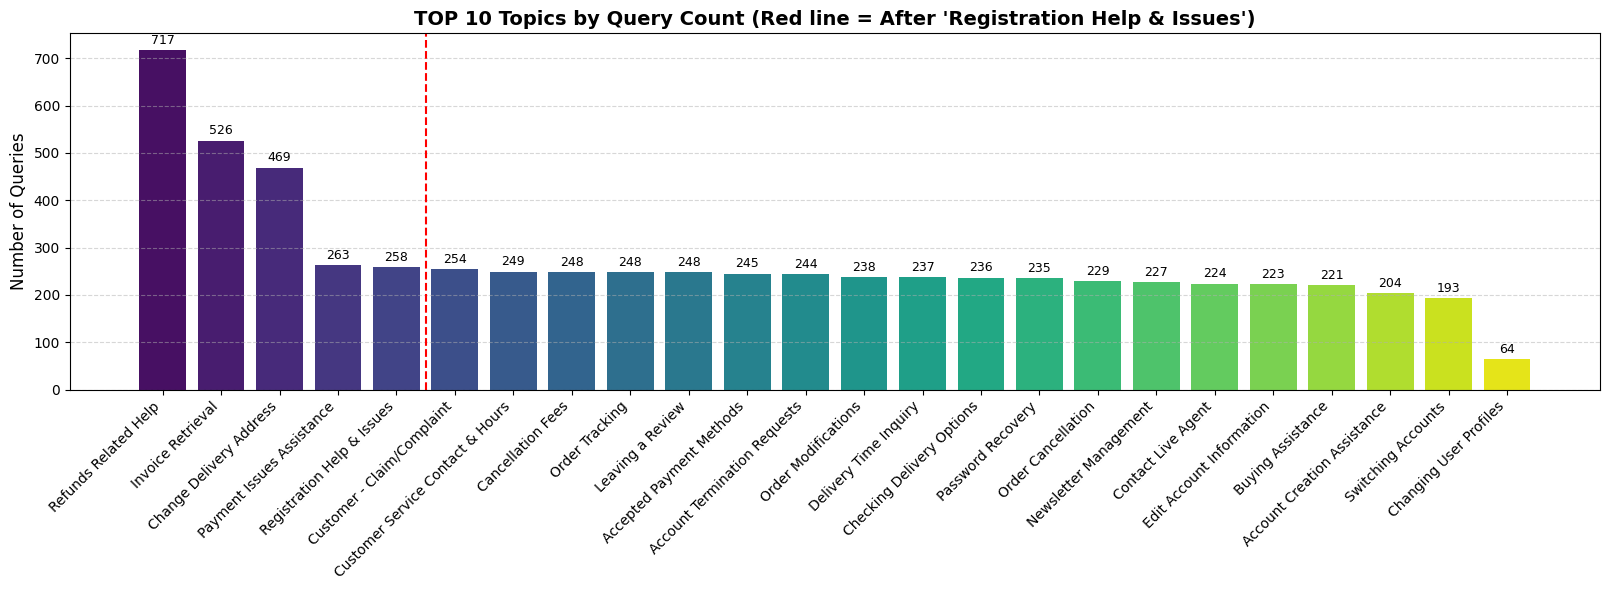

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # for color palette
import pandas as pd

def show_topic_counts(df, N=10):
    # Count topic labels
    topic_counts = df['topic_label_final'].value_counts().sort_values(ascending=False)
    top_topics = topic_counts.head(N)

    labels = top_topics.index.tolist()
    counts = top_topics.values.tolist()

    # Find where "Registration & Sign-Up Issues" appears in current chart
    try:
        separator_index = labels.index("Leaving a review")
    except ValueError:
        separator_index = None  # Don't draw separator if it's not in top N

    x_pos = range(len(labels))  # positions for bars

    # Get distinct colors for bars using seaborn color palette
    colors = sns.color_palette("viridis", n_colors=len(labels))

    plt.figure(figsize=(max(10, 0.6 * N), 6))
    bars = plt.bar(x_pos, counts, color=colors)

    # Set topic labels at the x-axis with rotation for better readability
    plt.xticks(x_pos, labels, rotation=45, ha='right')

    # Annotate counts on top of each bar
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + max(counts)*0.01, str(count),
                 ha='center', va='bottom', fontsize=9)

    # Draw red separator line AFTER the 'Registration & Sign-Up Issues' bar
    if separator_index is not None:
        # Position on x-axis is separator_index + 0.5 for line after the bar
        plt.axvline(x=separator_index + 0.5, color='red', linestyle='--', linewidth=1.5)

    plt.ylabel("Number of Queries", fontsize=12)
    plt.title("TOP 10 Topics by Query Count (Red line = After 'Registration Help & Issues')",
              fontsize=14, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Example usage with your dataframe:
df = pd.read_csv("clustered_labelled_queries_final.csv", encoding="cp1252")

show_topic_counts(df, 27)


In [39]:
# 5 sample per topic

def show_sample_queries(df, n=5):
    print("\n📝 Sample Queries per Topic")
    print("=" * 60)

    grouped = df.groupby('topic_label_final')
    for topic, group in grouped:
        print(f"\n {topic} — {len(group)} queries")
        print("\n📝 Sample Queries:")
        print("-" * 40)
        samples = group['raw_query'].head(n).tolist()
        for query in samples:
            print(f"• {query}")

show_sample_queries(df)



📝 Sample Queries per Topic

 Accepted Payment Methods — 245 queries

📝 Sample Queries:
----------------------------------------
• allowed payment options
• assistance checking what payment methods are available
• assistance checking what payment methods you accept
• assistance checking your allowed payment methods
• assistance to check the available payment options

 Account Creation — 206 queries

📝 Sample Queries:
----------------------------------------
• acn ya help me creating a new online account
• assistance creating a bloody new account
• assistance creating a new user account
• assistance creating an online account
• assistance opening a new account

 Buying Assistance — 221 queries

📝 Sample Queries:
----------------------------------------
• assistance buying an item
• assistance buying several of your item
• assistance buying some of your item
• assistance buying something
• assistance making a purchase

 Cancellation Fees — 248 queries

📝 Sample Queries:
-----------------